# Point cloud classification with Pointnet using Keras


## Introduction

Classification of unordered 3D point sets i.e. point clouds
is a core problem in computer vision. This example implements the seminal point cloud
deep learning paper [PointNet (Qi et al., 2017)](https://arxiv.org/abs/1612.00593) for a synthetic dataset. 


## Setup

In [1]:
# !pip install tensorflow
# !pip install seaborn
import tensorflow as tf
print(tf.__version__)

2023-11-23 17:09:26.107775: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-23 17:09:27.336286: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


2.13.1


In [2]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt
from keras import callbacks

from DataSetsLoader import DataSetsLoader
from OrthogonalRegularizer import OrthogonalRegularizer

tf.random.set_seed(123)


## Load dataset

We use the Dublin synthetic dataset, there are 3 major classes taken in consideration namely building, trees and roads/ground.


Set the number of points to sample and batch size and parse the dataset.

In [3]:
NUM_POINTS = 4096
NUM_CLASSES = 3
BATCH_SIZE = 32

In [4]:
import os
import glob
from random import shuffle
import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt
from math import floor

class DataSetsLoader:
    def __init__(self, num_points=4096 , num_class=3): 
        self.num_points = num_points
        self.num_class = num_class
        self.load_datasets()
          

    def load_datasets(self):
        # os.chdir("/mnt/Z6Vs-project1/")
        os.chdir("/mnt/ogEk-realtime/")
        new_dir = os.getcwd()   
    
#stratified sampling
    def split_train_test_datasets(self, points, labels, split_size):
        idx_label1 = list([(idx) for idx, label in enumerate(labels) if label.lower() == 'b'])
        idx_label2 = list([(idx) for idx, label in enumerate(labels) if label.lower() == 'g'])
        idx_label3 = list([(idx) for idx, label in enumerate(labels) if label.lower() == 'v'])
        
        split_index1 = floor(len(idx_label1) * split_size)
        split_index2 = floor(len(idx_label2) * split_size)
        split_index3 = floor(len(idx_label3) * split_size)
        
        train_idx = idx_label1[:split_index1] + idx_label2[:split_index2] + idx_label3[:split_index3]
        test_idx  = idx_label1[split_index1:] + idx_label2[split_index2:] + idx_label3[split_index3:] 
        shuffle(train_idx)
        shuffle(test_idx)
        train_points = list([points[i] for i in train_idx])
        train_labels = list([labels[i] for i in train_idx])
        test_points = list([points[i] for i in test_idx])
        test_labels = list([labels[i] for i in test_idx])  
        
        return(train_points,test_points,train_labels,test_labels)
    
    def transform_to_tensorflow_dataset(self, split_size=0.80, split_size_val = 0.75):
        points = []
        labels = []
        train_points = []
        train_labels = []
        test_points = []
        test_labels = []
        
        # all_files = os.listdir("/mnt/Z6Vs-project1/")
        all_files = os.listdir("/mnt/ogEk-realtime/")
        data_files = list(filter(lambda file: file.endswith('.txt'), all_files))
        shuffle(data_files)

        for f in data_files: 
            # os.chdir(r"/mnt/Z6Vs-project1/")                       
            os.chdir(r"/mnt/ogEk-realtime/") 
            try:
                data = pd.read_csv(f, sep=" ")
                data = data.fillna(method='ffill').fillna(method='bfill')
                if(f[0].lower() == 'b'):
                    data['R'], data['G'], data['B'] = [0, 1, 0]
                if(f[0].lower() == 'g'):
                    data['R'], data['G'], data['B'] = [1, 0, 0]
                if(f[0].lower() == 'v'):
                    data['R'], data['G'], data['B'] = [0, 1, 0]
                
                if (len(data)>=self.num_points):
                     #We sample a point cloud file using `.sample()` which performs a unifrom random sampling. Here we sample at 4096 locations
                    points.append(data.sample(self.num_points))  
                    labels.append(f[0])
                    # print(points)
                    # if(f[0].lower() == 'b'):
                    #     z = np.zeros(points.shape)
                    #     z = np.concatenate((points, z), axis=2)
                    #     z[:, :, 3]=1
                    # if(f[0].lower() == 'g'):
                    #     z = np.zeros(points.shape)
                    #     z = np.concatenate((points, z), axis=2)
                    #     z[:, :, 4]=1
                    # if(f[0].lower() == 'v'):
                    #     z = np.zeros(points.shape)
                    #     z = np.concatenate((points, z), axis=2)
                    #     z[:, :, 5]=1
                    # points = z
                    # print(z)
                    # print("Now next please")
            except Exception as e:
                print(e)
        
        
        train_points, test_points, train_labels, test_labels = self.split_train_test_datasets(points, labels, split_size)
        train_points, val_points, train_labels, val_labels = self.split_train_test_datasets(train_points, train_labels, split_size_val)
        
        return (
            np.array(train_points),
            np.array(test_points),
            np.array(val_points),
            np.array(train_labels),
            np.array(test_labels),         
            np.array(val_labels)
        )  

In [5]:
# Load Datasets
datasets_loader = DataSetsLoader(NUM_POINTS,NUM_CLASSES)
train_points, test_points, val_points, train_labels, test_labels, val_labels = datasets_loader.transform_to_tensorflow_dataset()

In [6]:
print(train_labels)
print(val_labels)
print(test_labels)

['g' 'g' 'V' 'b' 'b' 'V' 'g' 'b' 'g' 'b' 'g' 'g' 'b' 'V' 'b' 'b' 'b' 'b'
 'g' 'b' 'b' 'V' 'b' 'g' 'g' 'g' 'g' 'b' 'b' 'g' 'g' 'b' 'V' 'g' 'b' 'b'
 'b' 'b' 'b' 'b' 'g' 'g' 'g' 'g' 'b' 'g' 'V' 'V' 'b' 'g' 'b' 'b' 'b' 'b'
 'g' 'b' 'V' 'g' 'g' 'g' 'b' 'b' 'g' 'g' 'b' 'g']
['g' 'b' 'b' 'g' 'b' 'g' 'g' 'b' 'g' 'b' 'g' 'b' 'g' 'g' 'V' 'b' 'b' 'V'
 'b' 'b' 'b' 'g' 'V']
['g' 'b' 'g' 'V' 'g' 'b' 'g' 'g' 'V' 'g' 'b' 'b' 'b' 'g' 'b' 'b' 'g' 'b'
 'V' 'b' 'b' 'g' 'g' 'b']


In [7]:
# z = np.zeros((24,4096,3))
# # z = np.append((test_points, z), axis = 2)
# # z

# z = np.concatenate((test_points, z), axis=2)
# z.shape

In [8]:
# z[:, :, 3]=1

In [9]:
print(train_points.shape)
print(val_points.shape)
print(test_points.shape)

(66, 4096, 6)
(23, 4096, 6)
(24, 4096, 6)


In [10]:
#Check for any Nans
import math
np.argwhere(np.isnan(train_points))

array([], shape=(0, 3), dtype=int64)

In [11]:
def label_mapping(lbl):
    if(lbl.lower() == 'b'):
        return 0
    if(lbl.lower() == 'g'):
        return 1
    if(lbl.lower() == 'v'):
        return 2
    else:
        return None

In [12]:
train_label=[]
test_label=[]
val_label=[]
for i in train_labels:
    label_train = label_mapping(i.lower())
    if(label_train!=None):
#         train_label.append(int(label_train))
        train_label.append(label_train)
        
for j in test_labels:  
    label_tst = label_mapping(j.lower())
    if(label_tst!=None):
        test_label.append(label_tst)

for k in val_labels:  
    label_val = label_mapping(k.lower())
    if(label_val!=None):
        val_label.append(label_val)
        
# train_label = tf.one_hot(train_label, depth=3)       
# test_label = tf.one_hot(test_label, depth=3)

print(train_label)    
print(test_label)
print(val_label)    

[1, 1, 2, 0, 0, 2, 1, 0, 1, 0, 1, 1, 0, 2, 0, 0, 0, 0, 1, 0, 0, 2, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 2, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 2, 2, 0, 1, 0, 0, 0, 0, 1, 0, 2, 1, 1, 1, 0, 0, 1, 1, 0, 1]
[1, 0, 1, 2, 1, 0, 1, 1, 2, 1, 0, 0, 0, 1, 0, 0, 1, 0, 2, 0, 0, 1, 1, 0]
[1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 2, 0, 0, 2, 0, 0, 0, 1, 2]


Our data can now be read into a `tf.data.Dataset()` object. We set the shuffle buffer
size to the entire size of the dataset as prior to this the data is ordered by class.
Data augmentation is important when working with point cloud data. We create a
augmentation function to jitter and shuffle the train dataset.


In [13]:

def augment(points, label):
    # jitter points
    points += tf.random.uniform(points.shape, -0.005, 0.005, dtype=tf.float64)
    # shuffle points
    points = tf.random.shuffle(points)
    return points, label


train_dataset = tf.data.Dataset.from_tensor_slices((train_points, train_label))
test_dataset = tf.data.Dataset.from_tensor_slices((test_points, test_label))
val_dataset = tf.data.Dataset.from_tensor_slices((val_points, val_label))

# train_dataset = train_dataset.shuffle(len(train_points)).map(augment).batch(BATCH_SIZE)
# val_dataset = val_dataset.shuffle(len(val_points)).batch(BATCH_SIZE)
# test_dataset = test_dataset.shuffle(len(test_points)).batch(BATCH_SIZE)

train_dataset = train_dataset.map(augment).batch(BATCH_SIZE)
val_dataset = val_dataset.batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

2023-11-23 17:09:34.238753: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [14]:
for i,j in test_dataset:
    if 2 in j:
        print(i)
        print("label")
        print(j)

tf.Tensor(
[[[148.48596192 112.44000245   1.58100128   1.           0.
     0.        ]
  [ 90.72900391 105.67300415   1.54600143   1.           0.
     0.        ]
  [ 44.61297608  73.07800293   1.21099854   1.           0.
     0.        ]
  ...
  [ 89.92596436  98.84600831   1.46799851   1.           0.
     0.        ]
  [ 24.38000489 116.43899537   1.93399811   1.           0.
     0.        ]
  [ 49.16699219  33.87600708   0.86500168   1.           0.
     0.        ]]

 [[  9.31396484   9.74798584  10.70800018   0.           1.
     0.        ]
  [ 12.17895507   5.53897095   7.22200012   0.           1.
     0.        ]
  [ 15.05895996  10.2709961    9.49900055   0.           1.
     0.        ]
  ...
  [  1.82397461   3.7709961    5.125        0.           1.
     0.        ]
  [ 10.62695312   2.99499512   4.9620018    0.           1.
     0.        ]
  [ 16.57897949  12.07998658   2.6570015    0.           1.
     0.        ]]

 [[ 19.04498291  36.44897461   5.10900116   1.   

### Build a model

Each convolution and fully-connected layer (with exception for end layers) consits of
Convolution / Dense -> Batch Normalization -> ReLU Activation.


PointNet consists of two core components. The primary MLP network, and the transformer
net (T-net). The T-net aims to learn an affine transformation matrix by its own mini
network. The T-net is used twice. The first time to transform the input features (n, 3)
into a canonical representation. The second is an affine transformation for alignment in
feature space (n, 3). As per the original paper we constrain the transformation to be
close to an orthogonal matrix (i.e. ||X*X^T - I|| = 0).

In [15]:

def conv_bn(x, filters):
    x = layers.Conv1D(filters, kernel_size=1, padding="valid")(x)
    x = layers.BatchNormalization(momentum=0.99)(x)
    # return layers.Activation("relu")(x)
    return layers.LeakyReLU(alpha=0.3)(x)


def dense_bn(x, filters):
    x = layers.Dense(filters)(x)
    x = layers.BatchNormalization(momentum=0.99)(x)
    # return layers.Activation("relu")(x)
    return layers.LeakyReLU(alpha=0.3)(x)



In [16]:
# class OrthogonalRegularizer(keras.regularizers.Regularizer):
#     def __init__(self, num_features, l2reg=0.001):        
#         self.num_features = num_features
#         self.l2reg = l2reg
#         self.eye = tf.eye(num_features)        

#     # gets called at each train iteration
#     def __call__(self, x): # your custom function here
#         x = tf.reshape(x, (-1, self.num_features, self.num_features))
#         xxt = tf.tensordot(x, x, axes=(2, 2))
#         xxt = tf.reshape(xxt, (-1, self.num_features, self.num_features))
#         return tf.reduce_sum(self.l2reg * tf.square(xxt - self.eye))

#     def get_config(self): # required class method
#         return {"num_features": self.num_features,
#                 "l2reg": self.l2reg}
    
# cl_test = OrthogonalRegularizer(3) 
# config_test_cl = cl_test.get_config() 
# print(config_test_cl) 
# cl_test_ = OrthogonalRegularizer.from_config(config_test_cl)


### tnet layer function

 We can then define a general function to build T-net layers, similar to fig: 
 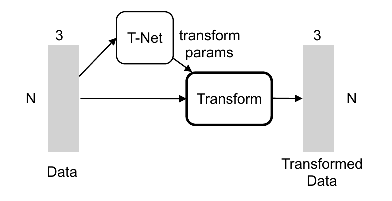

---




In [17]:

def tnet(inputs, num_features):

    # Initalise bias as the indentity matrix
    bias = keras.initializers.Constant(np.eye(num_features).flatten())
    reg = OrthogonalRegularizer(num_features)

    x = conv_bn(inputs, 32)
    x = conv_bn(x, 64)
    x = conv_bn(x, 512)
    x = layers.GlobalMaxPooling1D()(x)
    x = dense_bn(x, 256)
    x = dense_bn(x, 128)
    x = layers.Dense(
        num_features * num_features,
        kernel_initializer="zeros",
        bias_initializer=bias,
        activity_regularizer=reg,
    )(x)
    feat_T = layers.Reshape((num_features, num_features))(x)
    # Apply affine transformation to input features
    return layers.Dot(axes=(2, 1))([inputs, feat_T])



### Variable learning rate

The main network can be then implemented in the same manner where the t-net mini models
can be dropped in a layers in the graph. Here we replicate the network architecture
published in the original paper but with half the number of weights at each layer as we
are using the smaller 10 class ModelNet dataset.


In [18]:
initial_learning_rate = 0.001    
decay_steps = 7000  #200000
decay_rate = 0.7
# MOMENTUM = 0.99
def get_learning_rate(initial_learning_rate,decay_steps, decay_rate):
    
    learning_rate = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps, decay_rate, staircase=False, name=None)
    return learning_rate 

### Create model


In [19]:
def create_model():
    inputs = keras.Input(shape=(NUM_POINTS, 6))

    x = tnet(inputs, 6)
    x = conv_bn(x, 32)
    x = conv_bn(x, 32)
    x = tnet(x, 32)
    x = conv_bn(x, 32)
    x = conv_bn(x, 64)
    x = conv_bn(x, 512)
    x = layers.GlobalMaxPooling1D()(x)
    x = tf.keras.layers.Flatten()(x)
    x = dense_bn(x, 256)
    x = layers.Dropout(0.3)(x)
    x = dense_bn(x, 128)
    x = layers.Dropout(0.3)(x)

    outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)

    model = keras.Model(inputs=inputs, outputs=outputs, name="pointnet")
    return model

model = create_model()
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Adam(get_learning_rate(initial_learning_rate,decay_steps, decay_rate)),
    metrics=["sparse_categorical_accuracy"],
)
model.summary()

Model: "pointnet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 4096, 6)]            0         []                            
                                                                                                  
 conv1d (Conv1D)             (None, 4096, 32)             224       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 4096, 32)             128       ['conv1d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 leaky_re_lu (LeakyReLU)     (None, 4096, 32)             0         ['batch_normalization[0

### Train model

In [20]:
checkpoint_path = 'my_realtime_model_withRGB_save1'
es = keras.callbacks.EarlyStopping(monitor='val_sparse_categorical_accuracy', mode='max', verbose=1, start_from_epoch = 15, patience = 3)
mc = keras.callbacks.ModelCheckpoint(checkpoint_path, monitor='val_sparse_categorical_accuracy', mode='max', verbose=1)

history = model.fit(train_dataset, epochs=80, validation_data=val_dataset, callbacks = [es,mc])

Epoch 1/80
3/3 [==============================] - ETA: 0s - loss: 3.1099 - sparse_categorical_accuracy: 0.5303
Epoch 1: saving model to my_realtime_model_withRGB_save1
INFO:tensorflow:Assets written to: my_realtime_model_withRGB_save1/assets


INFO:tensorflow:Assets written to: my_realtime_model_withRGB_save1/assets


3/3 [==============================] - 29s 9s/step - loss: 3.1099 - sparse_categorical_accuracy: 0.5303 - val_loss: 5.5619 - val_sparse_categorical_accuracy: 0.3913
Epoch 2/80
3/3 [==============================] - ETA: 0s - loss: 2.6978 - sparse_categorical_accuracy: 0.7576
Epoch 2: saving model to my_realtime_model_withRGB_save1
INFO:tensorflow:Assets written to: my_realtime_model_withRGB_save1/assets


INFO:tensorflow:Assets written to: my_realtime_model_withRGB_save1/assets


3/3 [==============================] - 17s 7s/step - loss: 2.6978 - sparse_categorical_accuracy: 0.7576 - val_loss: 3.1882 - val_sparse_categorical_accuracy: 0.3913
Epoch 3/80
3/3 [==============================] - ETA: 0s - loss: 2.6951 - sparse_categorical_accuracy: 0.8485
Epoch 3: saving model to my_realtime_model_withRGB_save1
INFO:tensorflow:Assets written to: my_realtime_model_withRGB_save1/assets


INFO:tensorflow:Assets written to: my_realtime_model_withRGB_save1/assets


3/3 [==============================] - 17s 7s/step - loss: 2.6951 - sparse_categorical_accuracy: 0.8485 - val_loss: 2.8998 - val_sparse_categorical_accuracy: 0.3913
Epoch 4/80
3/3 [==============================] - ETA: 0s - loss: 2.8102 - sparse_categorical_accuracy: 0.8182
Epoch 4: saving model to my_realtime_model_withRGB_save1
INFO:tensorflow:Assets written to: my_realtime_model_withRGB_save1/assets


INFO:tensorflow:Assets written to: my_realtime_model_withRGB_save1/assets


3/3 [==============================] - 17s 7s/step - loss: 2.8102 - sparse_categorical_accuracy: 0.8182 - val_loss: 2.7762 - val_sparse_categorical_accuracy: 0.4348
Epoch 5/80
3/3 [==============================] - ETA: 0s - loss: 2.7591 - sparse_categorical_accuracy: 0.9242
Epoch 5: saving model to my_realtime_model_withRGB_save1
INFO:tensorflow:Assets written to: my_realtime_model_withRGB_save1/assets


INFO:tensorflow:Assets written to: my_realtime_model_withRGB_save1/assets


3/3 [==============================] - 17s 7s/step - loss: 2.7591 - sparse_categorical_accuracy: 0.9242 - val_loss: 2.6880 - val_sparse_categorical_accuracy: 0.6087
Epoch 6/80
3/3 [==============================] - ETA: 0s - loss: 2.8526 - sparse_categorical_accuracy: 0.8636
Epoch 6: saving model to my_realtime_model_withRGB_save1
INFO:tensorflow:Assets written to: my_realtime_model_withRGB_save1/assets


INFO:tensorflow:Assets written to: my_realtime_model_withRGB_save1/assets


3/3 [==============================] - 18s 8s/step - loss: 2.8526 - sparse_categorical_accuracy: 0.8636 - val_loss: 2.5281 - val_sparse_categorical_accuracy: 0.7826
Epoch 7/80
3/3 [==============================] - ETA: 0s - loss: 2.7848 - sparse_categorical_accuracy: 0.9545
Epoch 7: saving model to my_realtime_model_withRGB_save1
INFO:tensorflow:Assets written to: my_realtime_model_withRGB_save1/assets


INFO:tensorflow:Assets written to: my_realtime_model_withRGB_save1/assets


3/3 [==============================] - 18s 7s/step - loss: 2.7848 - sparse_categorical_accuracy: 0.9545 - val_loss: 2.4766 - val_sparse_categorical_accuracy: 0.8261
Epoch 8/80
3/3 [==============================] - ETA: 0s - loss: 2.6990 - sparse_categorical_accuracy: 0.9697
Epoch 8: saving model to my_realtime_model_withRGB_save1
INFO:tensorflow:Assets written to: my_realtime_model_withRGB_save1/assets


INFO:tensorflow:Assets written to: my_realtime_model_withRGB_save1/assets


3/3 [==============================] - 18s 8s/step - loss: 2.6990 - sparse_categorical_accuracy: 0.9697 - val_loss: 2.3887 - val_sparse_categorical_accuracy: 0.8261
Epoch 9/80
3/3 [==============================] - ETA: 0s - loss: 2.6716 - sparse_categorical_accuracy: 0.9545
Epoch 9: saving model to my_realtime_model_withRGB_save1
INFO:tensorflow:Assets written to: my_realtime_model_withRGB_save1/assets


INFO:tensorflow:Assets written to: my_realtime_model_withRGB_save1/assets


3/3 [==============================] - 18s 7s/step - loss: 2.6716 - sparse_categorical_accuracy: 0.9545 - val_loss: 2.3430 - val_sparse_categorical_accuracy: 0.8696
Epoch 10/80
3/3 [==============================] - ETA: 0s - loss: 2.6129 - sparse_categorical_accuracy: 0.9697
Epoch 10: saving model to my_realtime_model_withRGB_save1
INFO:tensorflow:Assets written to: my_realtime_model_withRGB_save1/assets


INFO:tensorflow:Assets written to: my_realtime_model_withRGB_save1/assets


3/3 [==============================] - 18s 8s/step - loss: 2.6129 - sparse_categorical_accuracy: 0.9697 - val_loss: 2.3415 - val_sparse_categorical_accuracy: 0.8696
Epoch 11/80
3/3 [==============================] - ETA: 0s - loss: 2.5402 - sparse_categorical_accuracy: 0.9697
Epoch 11: saving model to my_realtime_model_withRGB_save1
INFO:tensorflow:Assets written to: my_realtime_model_withRGB_save1/assets


INFO:tensorflow:Assets written to: my_realtime_model_withRGB_save1/assets


3/3 [==============================] - 18s 8s/step - loss: 2.5402 - sparse_categorical_accuracy: 0.9697 - val_loss: 2.3707 - val_sparse_categorical_accuracy: 0.8696
Epoch 12/80
3/3 [==============================] - ETA: 0s - loss: 2.5211 - sparse_categorical_accuracy: 0.9848
Epoch 12: saving model to my_realtime_model_withRGB_save1
INFO:tensorflow:Assets written to: my_realtime_model_withRGB_save1/assets


INFO:tensorflow:Assets written to: my_realtime_model_withRGB_save1/assets


3/3 [==============================] - 17s 7s/step - loss: 2.5211 - sparse_categorical_accuracy: 0.9848 - val_loss: 2.3424 - val_sparse_categorical_accuracy: 0.8696
Epoch 13/80
3/3 [==============================] - ETA: 0s - loss: 2.5032 - sparse_categorical_accuracy: 0.9848
Epoch 13: saving model to my_realtime_model_withRGB_save1
INFO:tensorflow:Assets written to: my_realtime_model_withRGB_save1/assets


INFO:tensorflow:Assets written to: my_realtime_model_withRGB_save1/assets


3/3 [==============================] - 17s 7s/step - loss: 2.5032 - sparse_categorical_accuracy: 0.9848 - val_loss: 2.3033 - val_sparse_categorical_accuracy: 0.7826
Epoch 14/80
3/3 [==============================] - ETA: 0s - loss: 2.5202 - sparse_categorical_accuracy: 0.9848
Epoch 14: saving model to my_realtime_model_withRGB_save1
INFO:tensorflow:Assets written to: my_realtime_model_withRGB_save1/assets


INFO:tensorflow:Assets written to: my_realtime_model_withRGB_save1/assets


3/3 [==============================] - 17s 7s/step - loss: 2.5202 - sparse_categorical_accuracy: 0.9848 - val_loss: 2.2854 - val_sparse_categorical_accuracy: 0.7826
Epoch 15/80
3/3 [==============================] - ETA: 0s - loss: 2.4532 - sparse_categorical_accuracy: 1.0000
Epoch 15: saving model to my_realtime_model_withRGB_save1
INFO:tensorflow:Assets written to: my_realtime_model_withRGB_save1/assets


INFO:tensorflow:Assets written to: my_realtime_model_withRGB_save1/assets


3/3 [==============================] - 17s 7s/step - loss: 2.4532 - sparse_categorical_accuracy: 1.0000 - val_loss: 2.3086 - val_sparse_categorical_accuracy: 0.7826
Epoch 16/80
3/3 [==============================] - ETA: 0s - loss: 2.4036 - sparse_categorical_accuracy: 0.9848
Epoch 16: saving model to my_realtime_model_withRGB_save1
INFO:tensorflow:Assets written to: my_realtime_model_withRGB_save1/assets


INFO:tensorflow:Assets written to: my_realtime_model_withRGB_save1/assets


3/3 [==============================] - 17s 7s/step - loss: 2.4036 - sparse_categorical_accuracy: 0.9848 - val_loss: 2.3322 - val_sparse_categorical_accuracy: 0.7826
Epoch 17/80
3/3 [==============================] - ETA: 0s - loss: 2.3412 - sparse_categorical_accuracy: 1.0000
Epoch 17: saving model to my_realtime_model_withRGB_save1
INFO:tensorflow:Assets written to: my_realtime_model_withRGB_save1/assets


INFO:tensorflow:Assets written to: my_realtime_model_withRGB_save1/assets


3/3 [==============================] - 17s 7s/step - loss: 2.3412 - sparse_categorical_accuracy: 1.0000 - val_loss: 2.3540 - val_sparse_categorical_accuracy: 0.7826
Epoch 18/80
3/3 [==============================] - ETA: 0s - loss: 2.2818 - sparse_categorical_accuracy: 1.0000
Epoch 18: saving model to my_realtime_model_withRGB_save1
INFO:tensorflow:Assets written to: my_realtime_model_withRGB_save1/assets


INFO:tensorflow:Assets written to: my_realtime_model_withRGB_save1/assets


3/3 [==============================] - 18s 7s/step - loss: 2.2818 - sparse_categorical_accuracy: 1.0000 - val_loss: 2.3720 - val_sparse_categorical_accuracy: 0.7826
Epoch 19/80
3/3 [==============================] - ETA: 0s - loss: 2.2273 - sparse_categorical_accuracy: 1.0000
Epoch 19: saving model to my_realtime_model_withRGB_save1
INFO:tensorflow:Assets written to: my_realtime_model_withRGB_save1/assets


INFO:tensorflow:Assets written to: my_realtime_model_withRGB_save1/assets


3/3 [==============================] - 17s 7s/step - loss: 2.2273 - sparse_categorical_accuracy: 1.0000 - val_loss: 2.3870 - val_sparse_categorical_accuracy: 0.7826
Epoch 19: early stopping


## Training Loss Graph

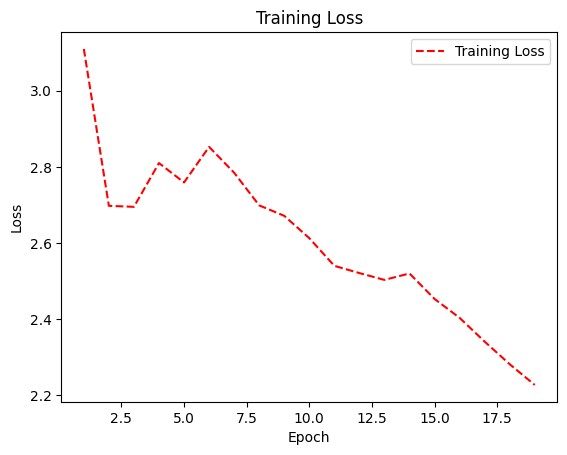

In [21]:
# Get training and test loss histories
training_loss = history.history['loss']
val_loss = history.history['val_loss']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss)+1)

# Visualize loss history
plt.plot(epoch_count, training_loss, 'r--')
# plt.plot(epoch_count, val_loss, 'b-')
plt.title('Training Loss')
plt.legend(['Training Loss', 'Val Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();

## Validation Loss Graph

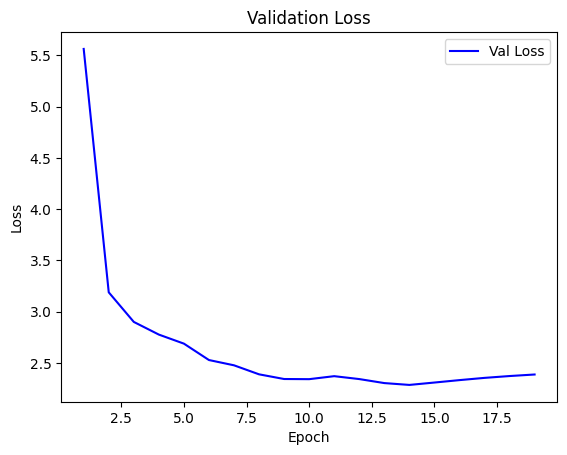

In [22]:
epoch_count = range(1, len(training_loss)+1)

plt.plot(epoch_count, val_loss, 'b-')
plt.legend(['Val Loss'])
plt.title('Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();

## Model Accuracy Graph

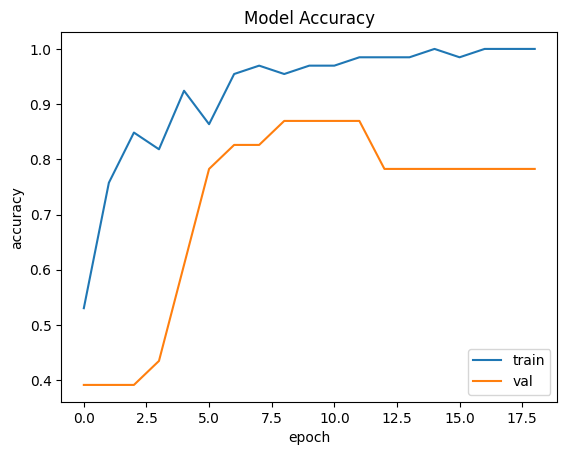

In [23]:
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.show()

# Model output after 107 epochs

The model was run for 150 epochs, because of early stopping, the model training was stopped at 107 epochs. But the accuracy achieved on both training and validation was less than values in prior epochs. So the model was saved when the validation accuracy was at its peak.
The results below are early stopping results:

## Visualize predictions

1/1 [==============================] - 1s 716ms/step


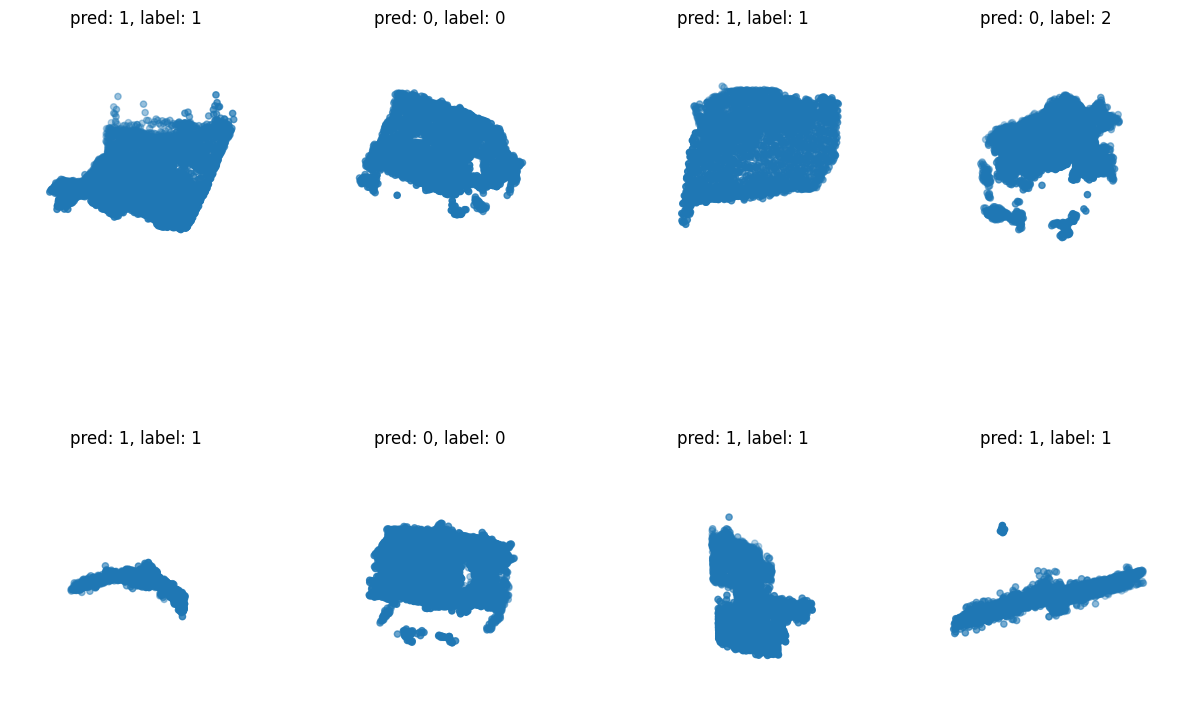

In [24]:
data = test_dataset.take(1)

points, labels = list(data)[0]
points = points[:8, ...]
labels = labels[:8, ...]

# run test data through model
preds = model.predict(points)
preds = tf.math.argmax(preds, -1)

points = points.numpy()

# plot points with predicted class and label
fig = plt.figure(figsize=(15, 10))
for i in range(8):
    ax = fig.add_subplot(2, 4, i + 1, projection="3d")
    ax.scatter(points[i, :, 0], points[i, :, 1], points[i, :, 2])
    ax.set_title(
        "pred: {:}, label: {:}".format(preds[i].numpy(),labels.numpy()[i])
    )
    ax.set_axis_off()
plt.show()


In [25]:
dataset = test_dataset
total_count = 0
correct_count = 0
expected = []
predicted = []
accuracy_arr = []

for element in dataset.as_numpy_iterator():
    points = element[0]
    labels = element[1]
    pred = model.predict(points)
    pred = tf.math.argmax(pred, -1)
    for index, point in enumerate(points):
        pred = model.predict(points)
        pred = tf.math.argmax(pred, -1)
        total_count += 1
        predicted.append(pred[index])
        expected.append(labels[index])
        if labels[index] == pred[index]:
            correct_count += 1
        
        accuracy  = correct_count / total_count
        print("Accuracy  is {}".format(accuracy))
        accuracy_arr.append(accuracy)
            
accuracy  = correct_count / total_count
print("Accuracy  is {}".format(accuracy))

1/1 [==============================] - 0s 327ms/step
Accuracy  is 1.0
1/1 [==============================] - 0s 341ms/step
Accuracy  is 1.0
1/1 [==============================] - 0s 348ms/step
Accuracy  is 1.0
1/1 [==============================] - 0s 341ms/step
Accuracy  is 0.75
1/1 [==============================] - 0s 335ms/step
Accuracy  is 0.8
1/1 [==============================] - 0s 332ms/step
Accuracy  is 0.8333333333333334
1/1 [==============================] - 0s 334ms/step
Accuracy  is 0.8571428571428571
1/1 [==============================] - 0s 302ms/step
Accuracy  is 0.875
1/1 [==============================] - 0s 319ms/step
Accuracy  is 0.7777777777777778
1/1 [==============================] - 0s 328ms/step
Accuracy  is 0.8
1/1 [==============================] - 0s 332ms/step
Accuracy  is 0.8181818181818182
1/1 [==============================] - 0s 328ms/step
Accuracy  is 0.8333333333333334
1/1 [==============================] - 0s 345ms/step
Accuracy  is 0.84615384615384

In [26]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns

In [27]:
label_names = np.array(['building','ground','vegetation'])

## Confusion Matrix

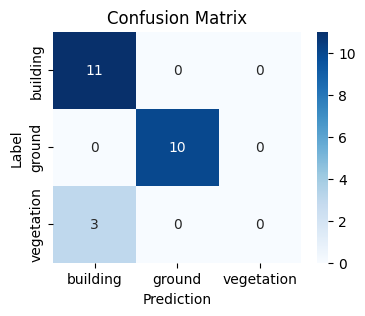

Accuracy: 0.875000
Precision: 0.875000
Recall: 0.875000
F1 score: 0.875000
              precision    recall  f1-score   support

    building       0.79      1.00      0.88        11
      ground       1.00      1.00      1.00        10
  vegetation       0.00      0.00      0.00         3

    accuracy                           0.88        24
   macro avg       0.60      0.67      0.63        24
weighted avg       0.78      0.88      0.82        24



/usr/local/lib64/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib64/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib64/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [28]:
confusion_mtx = tf.math.confusion_matrix(expected, predicted)
plt.figure(figsize=(4, 3))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g',cmap="Blues")
plt.title('Confusion Matrix')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

accuracy = accuracy_score(expected, predicted)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)  58/(58+6)  : was something else but predicted b,g,v
precision = precision_score(expected, predicted, average='micro')
print('Precision: %f' % precision)
# recall: tp / (tp + fn)   58/(58+6)  : was b,g,v but predicted as something else
recall = recall_score(expected, predicted, average='micro')
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)  2*58/(2*58+6+6)
f1 = f1_score(expected, predicted, average='micro')
print('F1 score: %f' % f1)

print(classification_report(expected, predicted,target_names=label_names))


# Saved model output

The results below are best model saved results:

In [29]:
# checkpoint_path = 'my_realtime_model_withRGB_save'
saved_model = create_model()
saved_model.load_weights(checkpoint_path)

2023-11-23 17:15:31.637930: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open my_realtime_model_withRGB_save1: DATA_LOSS: file is too short to be an sstable: perhaps your file is in a different file format and you need to use a different restore operator?


1/1 [==============================] - 1s 677ms/step


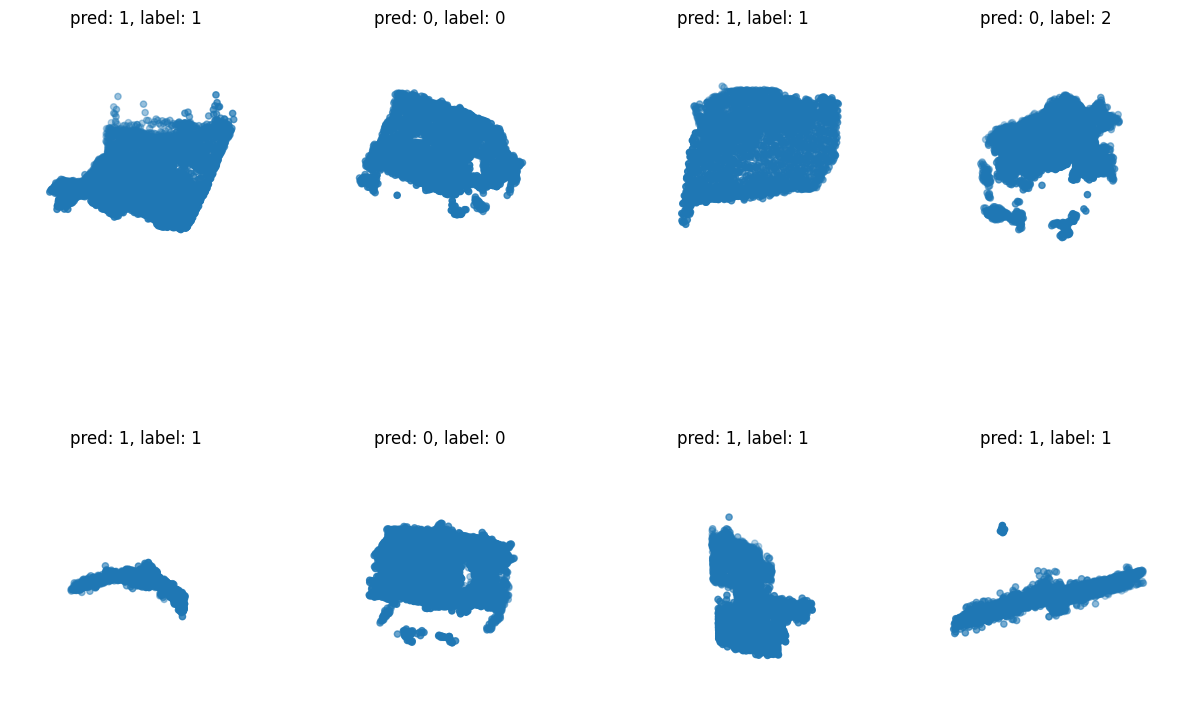

In [30]:
data = test_dataset.take(1)

points, labels = list(data)[0]
points = points[:8, ...]
labels = labels[:8, ...]

# run test data through model
preds = saved_model.predict(points)
preds = tf.math.argmax(preds, -1)

points = points.numpy()

# plot points with predicted class and label
fig = plt.figure(figsize=(15, 10))
for i in range(8):
    ax = fig.add_subplot(2, 4, i + 1, projection="3d")
    ax.scatter(points[i, :, 0], points[i, :, 1], points[i, :, 2])
    ax.set_title(
        "pred: {:}, label: {:}".format(preds[i].numpy(),labels.numpy()[i])
    )
    ax.set_axis_off()
plt.show()


# Test dataset predictions

In [31]:
dataset = test_dataset
total_count = 0
correct_count = 0
expected = []
predicted = []
accuracy_arr = []

for element in dataset.as_numpy_iterator():
    points = element[0]
    labels = element[1]
    pred = saved_model.predict(points)
    pred = tf.math.argmax(pred, -1)
    for index, point in enumerate(points):
        pred = saved_model.predict(points)
        pred = tf.math.argmax(pred, -1)
        total_count += 1
        predicted.append(pred[index])
        expected.append(labels[index])
        if labels[index] == pred[index]:
            correct_count += 1
        
        accuracy  = correct_count / total_count
        print("Accuracy  is {}".format(accuracy))
        accuracy_arr.append(accuracy)
            
accuracy  = correct_count / total_count
print("Accuracy  is {}".format(accuracy))

1/1 [==============================] - 0s 329ms/step
Accuracy  is 1.0
1/1 [==============================] - 0s 355ms/step
Accuracy  is 1.0
1/1 [==============================] - 0s 363ms/step
Accuracy  is 1.0
1/1 [==============================] - 0s 332ms/step
Accuracy  is 0.75
1/1 [==============================] - 0s 320ms/step
Accuracy  is 0.8
1/1 [==============================] - 0s 328ms/step
Accuracy  is 0.8333333333333334
1/1 [==============================] - 0s 327ms/step
Accuracy  is 0.8571428571428571
1/1 [==============================] - 0s 317ms/step
Accuracy  is 0.875
1/1 [==============================] - 0s 323ms/step
Accuracy  is 0.7777777777777778
1/1 [==============================] - 0s 313ms/step
Accuracy  is 0.8
1/1 [==============================] - 0s 322ms/step
Accuracy  is 0.8181818181818182
1/1 [==============================] - 0s 319ms/step
Accuracy  is 0.8333333333333334
1/1 [==============================] - 0s 342ms/step
Accuracy  is 0.84615384615384

In [32]:
label_names = np.array(['building','ground','vegetation'])

## Confusion Matrix

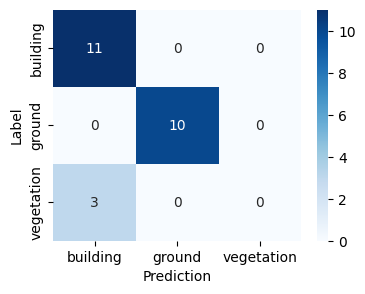

Accuracy: 0.875000
Precision: 0.875000
Recall: 0.875000
F1 score: 0.875000
              precision    recall  f1-score   support

    building       0.79      1.00      0.88        11
      ground       1.00      1.00      1.00        10
  vegetation       0.00      0.00      0.00         3

    accuracy                           0.88        24
   macro avg       0.60      0.67      0.63        24
weighted avg       0.78      0.88      0.82        24



/usr/local/lib64/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib64/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib64/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [33]:
confusion_mtx = tf.math.confusion_matrix(expected, predicted)
plt.figure(figsize=(4, 3))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g',cmap="Blues")
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

accuracy = accuracy_score(expected, predicted)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)  58/(58+6)  : was something else but predicted b,g,v
precision = precision_score(expected, predicted, average='micro')
print('Precision: %f' % precision)
# recall: tp / (tp + fn)   58/(58+6)  : was b,g,v but predicted as something else
recall = recall_score(expected, predicted, average='micro')
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)  2*58/(2*58+6+6)
f1 = f1_score(expected, predicted, average='micro')
print('F1 score: %f' % f1)

print(classification_report(expected, predicted,target_names=label_names))
